# Green's Function and TD-DMRG

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/block-hczhai/block2-preview/blob/master/docs/source/tutorial/greens-function.ipynb)

In [1]:
!pip install block2==0.5.2rc13 -qq --progress-bar off --extra-index-url=https://block-hczhai.github.io/block2-preview/pypi/
!pip install pyscf==2.3.0 -qq --progress-bar off

In the following example, we calculate the electron removal (IP) part of one-particle Green's function for Hydrogen chain ($\mathrm{H_6}$) in the minimal basis:

$$
    G_{ij}^-(\omega) = \langle \Psi_0 | a_j^\dagger \frac{1}{\omega + \hat{H}_0 - E_0 + i \eta} a_i |\Psi_0\rangle
$$

where $|\Psi_0\rangle$ is the ground state, $i = j = 2$ (counting from zero), $\eta = 0.005$.

The Green's function can be computed using DMRG in either the frequency domain (dynamical DMRG) or the time domain (time-dependent DMRG).

## Dynamical DMRG

We first solve the response equation to find the Green's function in the frequency domain.

Note that the return value of ``driver.greens_function`` method is the state:

$$|X_i\rangle := \frac{1}{\omega + \hat{H}_0 - E_0 + i \eta} a_i |\Psi_0\rangle
$$

Therefore, to get the value for Green's function with $i\neq j$, one can simply use ``driver.expectation`` to compute the dot product of $|X_i\rangle$ with some other $a_j|\Psi_0\rangle$.

In the ``SU2`` mode:

integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =        863

Build MPO | Nsites =     6 | Nterms =        863 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /     6 .. Mmpo =    13 DW = 0.00e+00 NNZ =       13 SPT = 0.0000 Tmvc = 0.000 T = 0.008
 Site =     1 /     6 .. Mmpo =    34 DW = 0.00e+00 NNZ =      100 SPT = 0.7738 Tmvc = 0.000 T = 0.004
 Site =     2 /     6 .. Mmpo =    56 DW = 0.00e+00 NNZ =      185 SPT = 0.9028 Tmvc = 0.000 T = 0.004
 Site =     3 /     6 .. Mmpo =    34 DW = 0.00e+00 NNZ =      419 SPT = 0.7799 Tmvc = 0.001 T = 0.004
 Site =     4 /     6 .. Mmpo =    14 DW = 0.00e+00 NNZ =      105 SPT = 0.7794 Tmvc = 0.000 T = 0.003
 Site =     5 /     6 .. Mmpo =     1 DW = 0.00e+00 NNZ =       14 SPT = 0.0000 Tmvc = 0.000 T = 0.002
Ttotal =      0.027 Tmvc-total = 0.002 MPO bond dimension =    56 MaxDW = 0.00e+00
NNZ =          836 SIZE =         4753 SPT = 0.8241

Rank =     0 Ttotal =      0.057 MPO method = FastBipartite bond dime

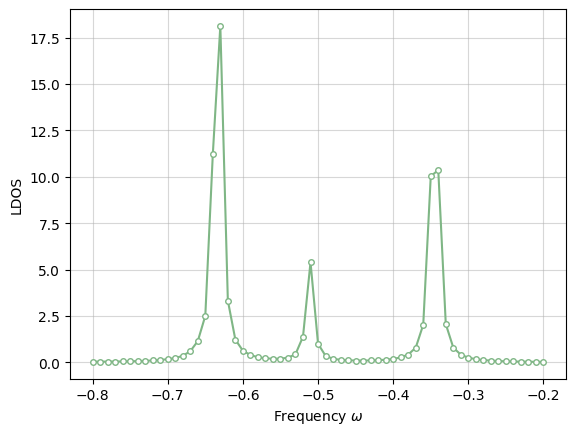

In [2]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from pyscf import gto, scf, lo

BOHR = 0.52917721092
R = 1.8 * BOHR
N = 6

mol = gto.M(atom=[['H', (i * R, 0, 0)] for i in range(N)], basis="sto6g", symmetry="c1", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)

mf.mo_coeff = lo.orth.lowdin(mol.intor('cint1e_ovlp_sph'))
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf, ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

bond_dims = [150] * 4 + [200] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, integral_cutoff=1E-8, iprint=1)
ket = driver.get_random_mps(tag="KET", bond_dim=150, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('Ground state energy = %20.15f' % energy)

isite = 2
mpo.const_e -= energy
eta = 0.005

dmpo = driver.get_site_mpo(op='D', site_index=isite, iprint=0)
dket = driver.get_random_mps(tag="DKET", bond_dim=200, center=ket.center, left_vacuum=dmpo.left_vacuum)
driver.multiply(dket, dmpo, ket, n_sweeps=10, bond_dims=[200], thrds=[1E-10] * 10, iprint=1)

freqs = np.arange(-0.8, -0.2, 0.01)
gfmat = np.zeros((len(freqs), ), dtype=complex)
for iw, freq in enumerate(freqs):
    bra = driver.copy_mps(dket, tag="BRA") # initial guess
    gfmat[iw] = driver.greens_function(bra, mpo, dmpo, ket, freq, eta, n_sweeps=6,
        bra_bond_dims=[200], ket_bond_dims=[200], thrds=[1E-6] * 10, iprint=0)
    print("FREQ = %8.2f GF[%d,%d] = %12.6f + %12.6f i" % (freq, isite, isite, gfmat[iw].real, gfmat[iw].imag))

ldos = -1 / np.pi * gfmat.imag

import matplotlib.pyplot as plt
plt.grid(which='major', axis='both', alpha=0.5)
plt.plot(freqs, ldos, linestyle='-', marker='o', markersize=4, mfc='white', mec="#7FB685", color="#7FB685")
plt.xlabel("Frequency $\\omega$")
plt.ylabel("LDOS")
plt.show()

In the ``SZ`` mode:

integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =       2286

Build MPO | Nsites =     6 | Nterms =       2286 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /     6 .. Mmpo =    26 DW = 0.00e+00 NNZ =       26 SPT = 0.0000 Tmvc = 0.001 T = 0.008
 Site =     1 /     6 .. Mmpo =    66 DW = 0.00e+00 NNZ =      243 SPT = 0.8584 Tmvc = 0.001 T = 0.011
 Site =     2 /     6 .. Mmpo =   110 DW = 0.00e+00 NNZ =      459 SPT = 0.9368 Tmvc = 0.002 T = 0.009
 Site =     3 /     6 .. Mmpo =    66 DW = 0.00e+00 NNZ =     1147 SPT = 0.8420 Tmvc = 0.001 T = 0.016
 Site =     4 /     6 .. Mmpo =    26 DW = 0.00e+00 NNZ =      243 SPT = 0.8584 Tmvc = 0.000 T = 0.006
 Site =     5 /     6 .. Mmpo =     1 DW = 0.00e+00 NNZ =       26 SPT = 0.0000 Tmvc = 0.000 T = 0.008
Ttotal =      0.057 Tmvc-total = 0.005 MPO bond dimension =   110 MaxDW = 0.00e+00
NNZ =         2144 SIZE =        18004 SPT = 0.8809

Rank =     0 Ttotal =      0.097 MPO method = FastBipartite bond dime

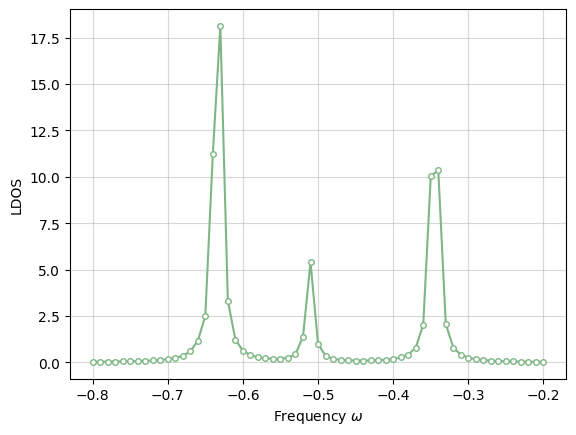

In [3]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from pyscf import gto, scf, lo

BOHR = 0.52917721092
R = 1.8 * BOHR
N = 6

mol = gto.M(atom=[['H', (i * R, 0, 0)] for i in range(N)], basis="sto6g", symmetry="c1", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)

mf.mo_coeff = lo.orth.lowdin(mol.intor('cint1e_ovlp_sph'))
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf, ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

bond_dims = [150] * 4 + [200] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, integral_cutoff=1E-8, iprint=1)
ket = driver.get_random_mps(tag="KET", bond_dim=150, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('Ground state energy = %20.15f' % energy)

isite = 2
mpo.const_e -= energy
eta = 0.005

dmpo = driver.get_site_mpo(op='d', site_index=isite, iprint=0) # only alpha spin
dket = driver.get_random_mps(tag="DKET", bond_dim=200, center=ket.center, target=dmpo.op.q_label + ket.info.target)
driver.multiply(dket, dmpo, ket, n_sweeps=10, bond_dims=[200], thrds=[1E-10] * 10, iprint=1)

freqs = np.arange(-0.8, -0.2, 0.01)
gfmat = np.zeros((len(freqs), ), dtype=complex)
for iw, freq in enumerate(freqs):
    bra = driver.copy_mps(dket, tag="BRA") # initial guess
    gfmat[iw] = driver.greens_function(bra, mpo, dmpo, ket, freq, eta, n_sweeps=6,
        bra_bond_dims=[200], ket_bond_dims=[200], thrds=[1E-6] * 10, iprint=0)
    print("FREQ = %8.2f GF[%d,%d] = %12.6f + %12.6f i" % (freq, isite, isite, gfmat[iw].real, gfmat[iw].imag))

ldos = -2 / np.pi * gfmat.imag # account for both spin

import matplotlib.pyplot as plt
plt.grid(which='major', axis='both', alpha=0.5)
plt.plot(freqs, ldos, linestyle='-', marker='o', markersize=4, mfc='white', mec="#7FB685", color="#7FB685")
plt.xlabel("Frequency $\\omega$")
plt.ylabel("LDOS")
plt.show()

## Time-Dependent DMRG

Here we use real time TD-DMRG and Fast Fourier Transform (FFT) to calculate the Green's function.

This is obtained from a Fourier transform from time domain to frequency domain:

$$
    G_{ij}(t) = - i \langle \Psi_0 | a_j^\dagger \mathrm{e}^{-i (\hat{H}_0 - E_0 ) t} a_i |\Psi_0\rangle \\
    G_{ij}(\omega) = \int_{-\infty}^{\infty} \mathrm{d} t \mathrm{e}^{-i \omega t} G_{ij}(t) \mathrm{e}^{- \eta t}
$$

where $\mathrm{e}^{- \eta t}$ is a broadening factor.

In the ``SU2`` mode:

integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =        863

Build MPO | Nsites =     6 | Nterms =        863 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /     6 .. Mmpo =    13 DW = 0.00e+00 NNZ =       13 SPT = 0.0000 Tmvc = 0.000 T = 0.014
 Site =     1 /     6 .. Mmpo =    34 DW = 0.00e+00 NNZ =      100 SPT = 0.7738 Tmvc = 0.000 T = 0.008
 Site =     2 /     6 .. Mmpo =    56 DW = 0.00e+00 NNZ =      185 SPT = 0.9028 Tmvc = 0.000 T = 0.008
 Site =     3 /     6 .. Mmpo =    34 DW = 0.00e+00 NNZ =      419 SPT = 0.7799 Tmvc = 0.000 T = 0.016
 Site =     4 /     6 .. Mmpo =    14 DW = 0.00e+00 NNZ =      105 SPT = 0.7794 Tmvc = 0.000 T = 0.013
 Site =     5 /     6 .. Mmpo =     1 DW = 0.00e+00 NNZ =       14 SPT = 0.0000 Tmvc = 0.001 T = 0.027
Ttotal =      0.087 Tmvc-total = 0.002 MPO bond dimension =    56 MaxDW = 0.00e+00
NNZ =          836 SIZE =         4753 SPT = 0.8241

Rank =     0 Ttotal =      0.190 MPO method = FastBipartite bond dime

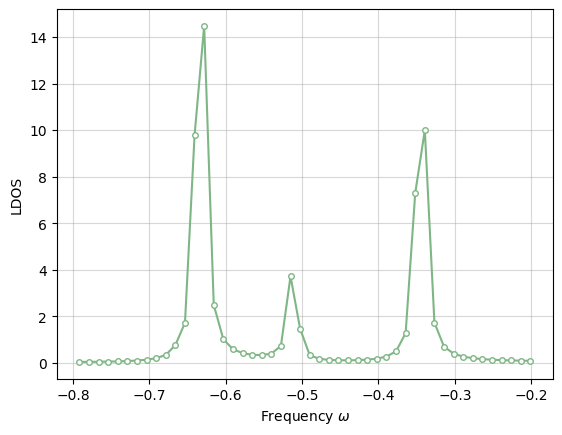

In [4]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from pyscf import gto, scf, lo

BOHR = 0.52917721092
R = 1.8 * BOHR
N = 6

mol = gto.M(atom=[['H', (i * R, 0, 0)] for i in range(N)], basis="sto6g", symmetry="c1", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)

mf.mo_coeff = lo.orth.lowdin(mol.intor('cint1e_ovlp_sph'))
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf, ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SU2 | SymmetryTypes.CPX, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

bond_dims = [150] * 4 + [200] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, integral_cutoff=1E-8, iprint=1)
ket = driver.get_random_mps(tag="KET", bond_dim=150, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('Ground state energy = %20.15f' % energy)

isite = 2
mpo.const_e -= energy
eta = 0.005

dmpo = driver.get_site_mpo(op='D', site_index=isite, iprint=0)
dket = driver.get_random_mps(tag="DKET", bond_dim=200, center=ket.center, left_vacuum=dmpo.left_vacuum)
driver.multiply(dket, dmpo, ket, n_sweeps=10, bond_dims=[200], thrds=[1E-10] * 10, iprint=1)

impo = driver.get_identity_mpo()
dbra = driver.copy_mps(dket, tag='DBRA')

dt = 0.2
t = 500.0
nstep = int(t / dt)
rtgf = np.zeros((nstep, ), dtype=complex)
rtgf[0] = driver.expectation(dket, impo, dket)
for it in range(nstep - 1):
    if it % (nstep // 100) == 0:
        print("it = %5d (%4.1f %%)" % (it, it * 100 / nstep))
    dbra = driver.td_dmrg(mpo, dbra, -dt * 1j, -dt * 1j, final_mps_tag='DBRA', hermitian=True, bond_dims=[200], iprint=0)
    rtgf[it + 1] = driver.expectation(dbra, impo, dket)

def gf_fft(eta, dt, rtgf, npts):
    frq = np.fft.fftfreq(npts, dt)
    frq = np.fft.fftshift(frq) * 2.0 * np.pi
    fftinp = -1j * rtgf * np.exp(-eta * dt * np.arange(0, npts))
    return frq, np.fft.fftshift(np.fft.fft(fftinp)) * dt

frq, frq_gf = gf_fft(eta, dt, rtgf, len(rtgf))
frq_gf = frq_gf[(frq >= -0.8) & (frq < -0.2)]
frq = frq[(frq >= -0.8) & (frq < -0.2)]

ldos = -1 / np.pi * frq_gf.imag

import matplotlib.pyplot as plt
plt.grid(which='major', axis='both', alpha=0.5)
plt.plot(frq, ldos, linestyle='-', marker='o', markersize=4, mfc='white', mec="#7FB685", color="#7FB685")
plt.xlabel("Frequency $\\omega$")
plt.ylabel("LDOS")
plt.show()

In the ``SZ`` mode:

integral symmetrize error =  0.0
integral cutoff error =  0.0
mpo terms =       2286

Build MPO | Nsites =     6 | Nterms =       2286 | Algorithm = FastBIP | Cutoff = 1.00e-20
 Site =     0 /     6 .. Mmpo =    26 DW = 0.00e+00 NNZ =       26 SPT = 0.0000 Tmvc = 0.001 T = 0.016
 Site =     1 /     6 .. Mmpo =    66 DW = 0.00e+00 NNZ =      243 SPT = 0.8584 Tmvc = 0.001 T = 0.016
 Site =     2 /     6 .. Mmpo =   110 DW = 0.00e+00 NNZ =      459 SPT = 0.9368 Tmvc = 0.001 T = 0.014
 Site =     3 /     6 .. Mmpo =    66 DW = 0.00e+00 NNZ =     1147 SPT = 0.8420 Tmvc = 0.001 T = 0.013
 Site =     4 /     6 .. Mmpo =    26 DW = 0.00e+00 NNZ =      243 SPT = 0.8584 Tmvc = 0.000 T = 0.004
 Site =     5 /     6 .. Mmpo =     1 DW = 0.00e+00 NNZ =       26 SPT = 0.0000 Tmvc = 0.000 T = 0.003
Ttotal =      0.066 Tmvc-total = 0.004 MPO bond dimension =   110 MaxDW = 0.00e+00
NNZ =         2144 SIZE =        18004 SPT = 0.8809

Rank =     0 Ttotal =      0.124 MPO method = FastBipartite bond dime

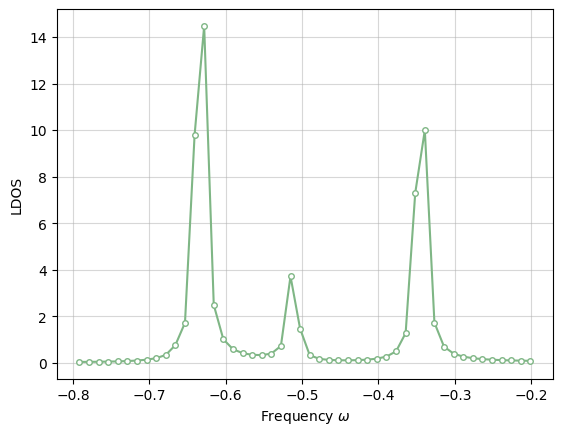

In [5]:
import numpy as np
from pyblock2._pyscf.ao2mo import integrals as itg
from pyblock2.driver.core import DMRGDriver, SymmetryTypes
from pyscf import gto, scf, lo

BOHR = 0.52917721092
R = 1.8 * BOHR
N = 6

mol = gto.M(atom=[['H', (i * R, 0, 0)] for i in range(N)], basis="sto6g", symmetry="c1", verbose=0)
mf = scf.RHF(mol).run(conv_tol=1E-14)

mf.mo_coeff = lo.orth.lowdin(mol.intor('cint1e_ovlp_sph'))
ncas, n_elec, spin, ecore, h1e, g2e, orb_sym = itg.get_rhf_integrals(mf, ncore=0, ncas=None, g2e_symm=8)

driver = DMRGDriver(scratch="./tmp", symm_type=SymmetryTypes.SZ | SymmetryTypes.CPX, n_threads=4)
driver.initialize_system(n_sites=ncas, n_elec=n_elec, spin=spin, orb_sym=orb_sym)

bond_dims = [150] * 4 + [200] * 4
noises = [1e-4] * 4 + [1e-5] * 4 + [0]
thrds = [1e-10] * 8

mpo = driver.get_qc_mpo(h1e=h1e, g2e=g2e, ecore=ecore, integral_cutoff=1E-8, iprint=1)
ket = driver.get_random_mps(tag="KET", bond_dim=150, nroots=1)
energy = driver.dmrg(mpo, ket, n_sweeps=20, bond_dims=bond_dims, noises=noises,
    thrds=thrds, iprint=1)
print('Ground state energy = %20.15f' % energy)

isite = 2
mpo.const_e -= energy
eta = 0.005

dmpo = driver.get_site_mpo(op='d', site_index=isite, iprint=0) # only alpha spin
dket = driver.get_random_mps(tag="DKET", bond_dim=200, center=ket.center, target=dmpo.op.q_label + ket.info.target)
driver.multiply(dket, dmpo, ket, n_sweeps=10, bond_dims=[200], thrds=[1E-10] * 10, iprint=1)

impo = driver.get_identity_mpo()
dbra = driver.copy_mps(dket, tag='DBRA')

dt = 0.2
t = 500.0
nstep = int(t / dt)
rtgf = np.zeros((nstep, ), dtype=complex)
rtgf[0] = driver.expectation(dket, impo, dket)
for it in range(nstep - 1):
    if it % (nstep // 100) == 0:
        print("it = %5d (%4.1f %%)" % (it, it * 100 / nstep))
    dbra = driver.td_dmrg(mpo, dbra, -dt * 1j, -dt * 1j, final_mps_tag='DBRA', hermitian=True, bond_dims=[200], iprint=0)
    rtgf[it + 1] = driver.expectation(dbra, impo, dket)

def gf_fft(eta, dt, rtgf, npts):
    frq = np.fft.fftfreq(npts, dt)
    frq = np.fft.fftshift(frq) * 2.0 * np.pi
    fftinp = -1j * rtgf * np.exp(-eta * dt * np.arange(0, npts))
    return frq, np.fft.fftshift(np.fft.fft(fftinp)) * dt

frq, frq_gf = gf_fft(eta, dt, rtgf, len(rtgf))
frq_gf = frq_gf[(frq >= -0.8) & (frq < -0.2)]
frq = frq[(frq >= -0.8) & (frq < -0.2)]

ldos = -2 / np.pi * frq_gf.imag

import matplotlib.pyplot as plt
plt.grid(which='major', axis='both', alpha=0.5)
plt.plot(frq, ldos, linestyle='-', marker='o', markersize=4, mfc='white', mec="#7FB685", color="#7FB685")
plt.xlabel("Frequency $\\omega$")
plt.ylabel("LDOS")
plt.show()